<a href="https://colab.research.google.com/github/tomhanna-uh/data-2025/blob/main/GRAVE_M_Data_Loader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import pandas as pd
import numpy as np
# Explicitly enable experimental MICE support
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import os
import sys

# Check if running in Colab to import specific tools
if 'google.colab' in sys.modules:
    from google.colab import files

def run_mice_step_1(input_filename="GRAVE_M_Master_Dataset_Final_v3_factors.csv",
                    output_filename="GRAVE_M_Master_Dataset_Final_v3_imputed.csv"):
    """
    STEP 1: Load Raw Data -> Run MICE Imputation -> Save Result.
    """
    # -------------------------------------------------------------------------
    # 1. LOAD DATA FROM FILE
    # -------------------------------------------------------------------------
    # Robust search for the file
    file_path = None
    if os.path.exists(input_filename):
        file_path = input_filename
    else:
        # Search current directory tree
        for root, dirs, current_files in os.walk(os.getcwd()):
            if input_filename in current_files:
                file_path = os.path.join(root, input_filename)
                break

    # Prompt for upload if not found (Colab specific)
    if file_path is None:
        print(f"File '{input_filename}' not found.")
        if 'google.colab' in sys.modules:
            print("\n--- ACTION REQUIRED: UPLOAD RAW DATA ---")
            print(f"Please upload '{input_filename}' now.")
            uploaded = files.upload()
            if input_filename in uploaded:
                file_path = input_filename
            elif len(uploaded) > 0:
                # Handle case where user uploads file with different name
                file_path = list(uploaded.keys())[0]
                print(f"Using uploaded file: {file_path}")
            else:
                raise FileNotFoundError("No file uploaded.")
        else:
            raise FileNotFoundError(f"File {input_filename} not found.")

    print(f"Loading raw data from: {file_path}")
    df = pd.read_csv(file_path)

    # -------------------------------------------------------------------------
    # 2. DEFINE IMPUTATION LOGIC
    # -------------------------------------------------------------------------
    # Variables to Impute (Missing at Random)
    target_cols = [
        "fraser_bmp_score",   # Black Market Premium
        "gini_disp",          # Inequality
        "resource_rents",     # Rents % GDP
        "log_oil_gas_wealth", # Ross Data
        "unified_gdp_pc",     # Minor gaps
        "unified_pop"
    ]

    # Predictor Variables (Complete/High Quality)
    predictor_cols = [
        "year",
        "v2x_libdem",
        "is_petro_state",      # Raw CSV has this as 0/1 (Perfect for MICE)
        "unified_corruption",
        "COWcode"
    ]

    # Create subset for imputation
    impute_subset = df[target_cols + predictor_cols].copy()

    # -------------------------------------------------------------------------
    # 3. EXECUTE MICE
    # -------------------------------------------------------------------------
    print("\n--- STARTING MICE IMPUTATION ---")
    print(f"Targets: {target_cols}")

    # max_iter=10: Sufficient for convergence
    # sample_posterior=True: Standard MICE approach for uncertainty
    imputer = IterativeImputer(max_iter=10, random_state=42, sample_posterior=True)

    imputed_array = imputer.fit_transform(impute_subset)
    imputed_df_subset = pd.DataFrame(imputed_array, columns=impute_subset.columns)

    # -------------------------------------------------------------------------
    # 4. MERGE & UPDATE
    # -------------------------------------------------------------------------
    df_clean = df.copy()

    for col in target_cols:
        missing_n = df_clean[col].isna().sum()
        df_clean[col] = imputed_df_subset[col]
        print(f"  - {col}: Filled {missing_n} missing values.")

    # Update Log Transforms for consistency
    if "unified_gdp_pc" in target_cols:
        df_clean["log_gdp_pc"] = np.log1p(df_clean["unified_gdp_pc"])
    if "unified_pop" in target_cols:
        df_clean["log_pop"] = np.log1p(df_clean["unified_pop"])

    # -------------------------------------------------------------------------
    # 5. SAVE RESULT
    # -------------------------------------------------------------------------
    print(f"\nSaving imputed dataset to: {output_filename}")
    df_clean.to_csv(output_filename, index=False)
    print("Done. Proceed to Step 2 (Data Loader).")

    return df_clean

# Run the function
if __name__ == "__main__":
    run_mice_step_1()

File 'GRAVE_M_Master_Dataset_Final_v3_factors.csv' not found.

--- ACTION REQUIRED: UPLOAD RAW DATA ---
Please upload 'GRAVE_M_Master_Dataset_Final_v3_factors.csv' now.


Saving GRAVE_M_Master_Dataset_Final_v3.csv to GRAVE_M_Master_Dataset_Final_v3 (3).csv
Using uploaded file: GRAVE_M_Master_Dataset_Final_v3 (3).csv
Loading raw data from: GRAVE_M_Master_Dataset_Final_v3 (3).csv

--- STARTING MICE IMPUTATION ---
Targets: ['fraser_bmp_score', 'gini_disp', 'resource_rents', 'log_oil_gas_wealth', 'unified_gdp_pc', 'unified_pop']
  - fraser_bmp_score: Filled 8934 missing values.
  - gini_disp: Filled 7092 missing values.
  - resource_rents: Filled 6639 missing values.
  - log_oil_gas_wealth: Filled 4206 missing values.
  - unified_gdp_pc: Filled 1521 missing values.
  - unified_pop: Filled 1106 missing values.

Saving imputed dataset to: GRAVE_M_Master_Dataset_Final_v3_imputed.csv


/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


Done. Proceed to Step 2 (Data Loader).


In [11]:
import pandas as pd
import os
import sys

# Check if running in Colab to import specific tools
if 'google.colab' in sys.modules:
    from google.colab import files

def load_grave_m_data_step_2(filename="GRAVE_M_Master_Dataset_Final_v3_imputed.csv"):
    """
    STEP 2: Load Imputed Data -> Cast Categorical Variables -> Ready for TFT.
    """
    # -------------------------------------------------------------------------
    # 1. LOCATE THE FILE
    # -------------------------------------------------------------------------
    print(f"Searching for '{filename}'...")

    file_path = None
    # Search current directory tree
    for root, dirs, current_files in os.walk(os.getcwd()):
        if filename in current_files:
            file_path = os.path.join(root, filename)
            print(f"Found file at: {file_path}")
            break

    # Prompt for upload if not found (Colab specific)
    if file_path is None:
        print(f"File '{filename}' not found.")

        if 'google.colab' in sys.modules:
            print("\n--- ACTION REQUIRED: UPLOAD IMPUTED DATA ---")
            print("The imputed file from Step 1 was not found.")
            print("1. Look for the 'Choose Files' button below.")
            print("2. Upload 'GRAVE_M_Master_Dataset_Final_v3_imputed.csv'.")

            uploaded = files.upload()

            if filename in uploaded:
                print(f"Successfully uploaded {filename}")
                file_path = os.path.join(os.getcwd(), filename)
            elif len(uploaded) > 0:
                uploaded_name = list(uploaded.keys())[0]
                file_path = os.path.join(os.getcwd(), uploaded_name)
                print(f"Filename mismatch. Using uploaded file: {uploaded_name}")
            else:
                raise FileNotFoundError("Upload cancelled or failed.")
        else:
             raise FileNotFoundError(f"Please ensure {filename} is in your working directory.")

    # -------------------------------------------------------------------------
    # 2. LOAD DATA
    # -------------------------------------------------------------------------
    print(f"Loading data from: {file_path}")
    df = pd.read_csv(file_path)

    # -------------------------------------------------------------------------
    # 3. DEFINE VARIABLE TYPES (Corrected Names for TFT)
    # -------------------------------------------------------------------------
    categorical_vars = [
        # Binary Indicators
        "is_petro_state",
        "is_aut_episode",
        "is_dem_episode",
        "alba_member",
        "mid_count_total",         # Replaces 'mid_onset'
        "mid_high_fatality_event", # Binary flag for high fatality
        "is_leftist_leader",
        "is_rightist_leader",

        # Ordinal / ID Variables
        "gli_leader_ideology_num", # 1, 2, 3
        "mid_max_fatality_cat",    # Replaces 'fatality' (0-6 scale)
        "mid_max_hostility",       # Ordinal scale (1-5)
        "COWcode",                 # Grouping ID
        "year"                     # Time Index
    ]

    # -------------------------------------------------------------------------
    # 4. TYPE CASTING
    # -------------------------------------------------------------------------
    print("Casting categorical variables...")
    for var in categorical_vars:
        if var in df.columns:
            # Convert to string first, then category.
            # This ensures '0' and '1' are treated as distinct labels, not numbers.
            df[var] = df[var].astype(str).astype("category")
            print(f"  - {var}: {len(df[var].unique())} unique levels")
        else:
            print(f"  [WARNING] Variable not found: {var}")

    return df

# -------------------------------------------------------------------------
# EXECUTION
# -------------------------------------------------------------------------
if __name__ == "__main__":
    try:
        # Load data (using default imputed filename)
        data = load_grave_m_data_step_2()

        print("\n--- DATA LOADING COMPLETE ---")
        print(data.info())
        print("\nDataset 'data' is now ready for PyTorch Forecasting.")

    except Exception as e:
        print(f"\nError: {e}")

Searching for 'GRAVE_M_Master_Dataset_Final_v3_imputed.csv'...
Found file at: /content/GRAVE_M_Master_Dataset_Final_v3_imputed.csv
Loading data from: /content/GRAVE_M_Master_Dataset_Final_v3_imputed.csv
Casting categorical variables...
  - is_petro_state: 2 unique levels
  - is_aut_episode: 2 unique levels
  - is_dem_episode: 2 unique levels
  - alba_member: 2 unique levels
  - mid_count_total: 26 unique levels
  - mid_high_fatality_event: 2 unique levels
  - is_leftist_leader: 2 unique levels
  - is_rightist_leader: 2 unique levels
  - gli_leader_ideology_num: 4 unique levels
  - mid_max_fatality_cat: 7 unique levels
  - mid_max_hostility: 5 unique levels
  - COWcode: 182 unique levels
  - year: 79 unique levels

--- DATA LOADING COMPLETE ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13080 entries, 0 to 13079
Data columns (total 78 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   country_name        

Using 'data' dataframe...
Setting up TimeSeriesDataSet...
Dropped 402 rows with invalid identifiers or missing targets.


/usr/local/lib/python3.12/dist-packages/pytorch_forecasting/data/timeseries/_timeseries.py:1850: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 1 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__COWcode': '626'}]
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pytorch_forecasting/data/timeseries/_timeseries.py:1850: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 1 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__COWcode': '626'}]
  warnings.warn(
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU co

Number of parameters in network: 37.7k

--- STARTING TRAINING ---


┏━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃    ┃ Name                               ┃ Type                            ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0  │ loss                               │ QuantileLoss                    │      0 │ train │     0 │
│ 1  │ logging_metrics                    │ ModuleList                      │      0 │ train │     0 │
│ 2  │ input_embeddings                   │ MultiEmbedding                  │  3.2 K │ train │     0 │
│ 3  │ prescalers                         │ ModuleDict                      │    224 │ train │     0 │
│ 4  │ static_variable_selection          │ VariableSelectionNetwork        │  1.9 K │ train │     0 │
│ 5  │ encoder_variable_selection         │ VariableSelectionNetwork        │  9.6 K │ train │     0 │
│ 6  │ decoder_variable_selection         │ VariableSelectionNetwork        │  8.9 K │ train │     0 │
│ 7  │ static_context_variable_selection  │ GatedResidualNetwork            │  1.1 K │ train │     0 │
│ 8  │ static_context_initial_hidden_lstm │ GatedResidualNetwork            │  1.1 K │ train │     0 │
│ 9  │ static_context_initial_cell_lstm   │ GatedResidualNetwork            │  1.1 K │ train │     0 │
│ 10 │ static_context_enrichment          │ GatedResidualNetwork            │  1.1 K │ train │     0 │
│ 11 │ lstm_encoder                       │ LSTM                            │  2.2 K │ train │     0 │
│ 12 │ lstm_decoder                       │ LSTM                            │  2.2 K │ train │     0 │
│ 13 │ post_lstm_gate_encoder             │ GatedLinearUnit                 │    544 │ train │     0 │
│ 14 │ post_lstm_add_norm_encoder         │ AddNorm                         │     32 │ train │     0 │
│ 15 │ static_enrichment                  │ GatedResidualNetwork            │  1.4 K │ train │     0 │
│ 16 │ multihead_attn                     │ InterpretableMultiHeadAttention │  1.1 K │ train │     0 │
│ 17 │ post_attn_gate_norm                │ GateAddNorm                     │    576 │ train │     0 │
│ 18 │ pos_wise_ff                        │ GatedResidualNetwork            │  1.1 K │ train │     0 │
│ 19 │ pre_output_gate_norm               │ GateAddNorm                     │    576 │ train │     0 │
│ 20 │ output_layer                       │ Linear                          │    119 │ train │     0 │
└────┴────────────────────────────────────┴─────────────────────────────────┴────────┴───────┴───────┘

Trainable params: 37.7 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 37.7 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 608                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO: Metric val_loss improved. New best score: 0.033
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 0.033
INFO: Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 0.026
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 0.026
INFO: Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.024
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.024
INFO: Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.023
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.023
INFO: Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.023
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.023
IN

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- MODEL SUMMARY ---
TemporalFusionTransformer(
  	"attention_head_size":               1
  	"categorical_groups":                {}
  	"causal_attention":                  True
  	"dataset_parameters":                {'time_idx': 'time_idx', 'target': 'v2x_libdem', 'group_ids': ['COWcode'], 'weight': None, 'max_encoder_length': 20, 'min_encoder_length': 10, 'min_prediction_idx': 1946, 'min_prediction_length': 1, 'max_prediction_length': 5, 'static_categoricals': ['COWcode'], 'static_reals': None, 'time_varying_known_categoricals': ['is_petro_state', 'is_aut_episode', 'is_dem_episode', 'alba_member', 'mid_count_total', 'mid_high_fatality_event', 'is_leftist_leader', 'is_rightist_leader', 'gli_leader_ideology_num', 'mid_max_fatality_cat', 'mid_max_hostility'], 'time_varying_known_reals': ['time_idx', 'unified_gdp_pc', 'log_gdp_pc', 'unified_pop', 'fraser_bmp_score', 'unified_corruption', 'resource_rents', 'gini_disp', 'atop_defense_with_auto'], 'time_varying_unknown_categoricals': Non

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



ATTENTION IMPORTANCE:


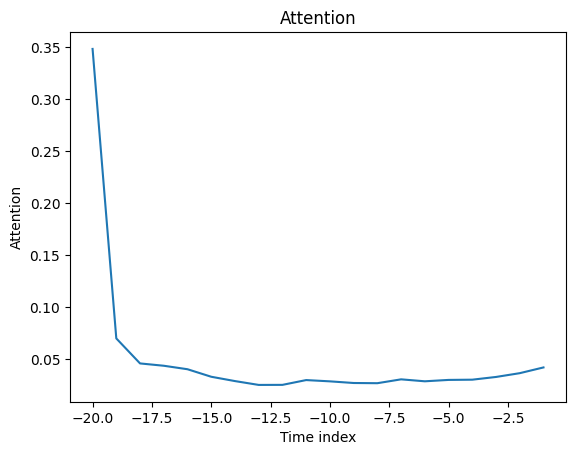

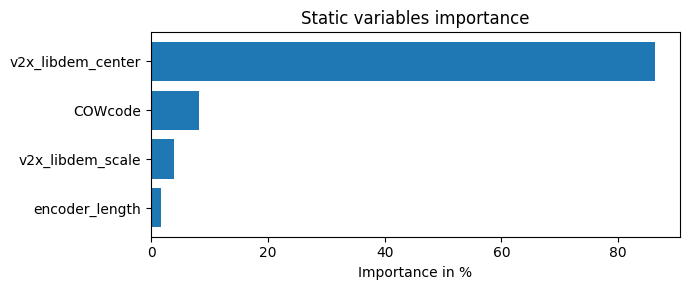

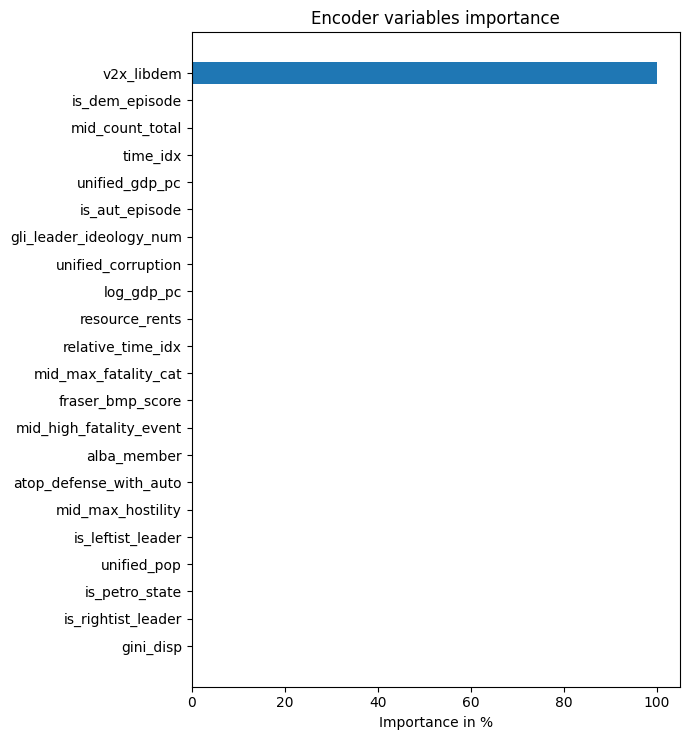

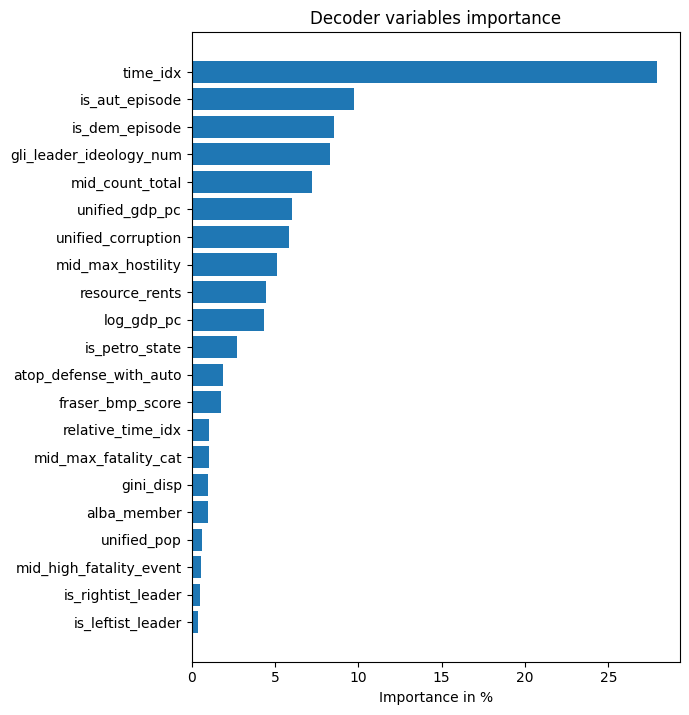


STATIC_VARIABLES IMPORTANCE:

ENCODER_VARIABLES IMPORTANCE:

DECODER_VARIABLES IMPORTANCE:


In [13]:
# !pip install --upgrade pytorch-lightning pytorch-forecasting

import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# UPDATED IMPORTS: Use lightning.pytorch instead of pytorch_lightning
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor
from lightning.pytorch.tuner import Tuner

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, Baseline
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.data.encoders import MultiNormalizer, TorchNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, QuantileLoss

# FIX: Register custom classes as safe for PyTorch 2.6+ checkpointing
torch.serialization.add_safe_globals([
    GroupNormalizer, MultiNormalizer, TorchNormalizer,
    pd.DataFrame, pd.Series, pd.Index
])

# -------------------------------------------------------------------------
# CONFIGURATION
# -------------------------------------------------------------------------
MAX_PREDICTION_LENGTH = 5   # Predict 5 years into the future
MAX_ENCODER_LENGTH = 20     # Look back at 20 years of history
BATCH_SIZE = 64
EPOCHS = 30                 # Reduced epochs for quicker feedback

# -------------------------------------------------------------------------
# 1. DEFINE DATASET
# -------------------------------------------------------------------------
def setup_tft_dataset(input_data):
    print("Setting up TimeSeriesDataSet...")

    data = input_data.copy()

    # 1. CLEAN STRUCTURE: Robust Drop & Type Enforcement
    data["COWcode"] = pd.to_numeric(data["COWcode"], errors='coerce')
    data["year"] = pd.to_numeric(data["year"], errors='coerce')

    # Drop missing TARGETS or IDENTIFIERS
    initial_len = len(data)
    data = data.dropna(subset=["COWcode", "year", "v2x_libdem"])

    if len(data) < initial_len:
        print(f"Dropped {initial_len - len(data)} rows with invalid identifiers or missing targets.")

    # 2. SANITIZE ECONOMIC VARIABLES (Fix Negative Imputations)
    cols_to_clip = ["unified_gdp_pc", "unified_pop", "resource_rents"]
    for col in cols_to_clip:
        if col in data.columns:
            data[col] = data[col].clip(lower=0)

    if "unified_gdp_pc" in data.columns:
        data["log_gdp_pc"] = np.log1p(data["unified_gdp_pc"])
    if "unified_pop" in data.columns:
        data["log_pop"] = np.log1p(data["unified_pop"])

    real_cols = [
        "unified_gdp_pc", "log_gdp_pc", "unified_pop", "fraser_bmp_score",
        "unified_corruption", "resource_rents", "gini_disp", "atop_defense_with_auto"
    ]
    for col in real_cols:
        if col in data.columns:
            data[col] = data[col].fillna(0)

    # 3. CATEGORICAL CASTING
    data["COWcode"] = data["COWcode"].astype(int).astype(str).astype("category")
    data["year"] = data["year"].astype(int)
    data["time_idx"] = data["year"]

    force_categoricals = [
        "is_petro_state",
        "is_aut_episode",
        "is_dem_episode",
        "alba_member",
        "mid_count_total",
        "mid_high_fatality_event",
        "is_leftist_leader",
        "is_rightist_leader",
        "gli_leader_ideology_num",
        "mid_max_fatality_cat",
        "mid_max_hostility"
    ]

    for var in force_categoricals:
        if var in data.columns:
            try:
                if data[var].dtype.name == 'category':
                     data[var] = data[var].astype(str).astype("category")
                else:
                    data[var] = pd.to_numeric(data[var], errors='coerce').fillna(-1)
                    data[var] = data[var].astype(int).astype(str).astype("category")
            except Exception as e:
                data[var] = data[var].astype(str).astype("category")

    # ---------------------------------------------------------------------
    # DEFINE DATASET OBJECT
    # ---------------------------------------------------------------------
    training_cutoff = data["time_idx"].max() - MAX_PREDICTION_LENGTH

    training = TimeSeriesDataSet(
        data[lambda x: x.time_idx <= training_cutoff],
        time_idx="time_idx",
        target="v2x_libdem",
        group_ids=["COWcode"],
        min_encoder_length=MAX_ENCODER_LENGTH // 2,
        max_encoder_length=MAX_ENCODER_LENGTH,
        min_prediction_length=1,
        max_prediction_length=MAX_PREDICTION_LENGTH,

        static_categoricals=["COWcode"],

        time_varying_known_categoricals=[
            "is_petro_state",
            "is_aut_episode",
            "is_dem_episode",
            "alba_member",
            "mid_count_total",
            "mid_high_fatality_event",
            "is_leftist_leader",
            "is_rightist_leader",
            "gli_leader_ideology_num",
            "mid_max_fatality_cat",
            "mid_max_hostility"
        ],

        time_varying_known_reals=[
            "time_idx",
            "unified_gdp_pc",
            "log_gdp_pc",
            "unified_pop",
            "fraser_bmp_score",
            "unified_corruption",
            "resource_rents",
            "gini_disp",
            "atop_defense_with_auto"
        ],

        time_varying_unknown_reals=[
            "v2x_libdem",
        ],

        target_normalizer=GroupNormalizer(
            groups=["COWcode"], transformation="softplus"
        ),

        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
        allow_missing_timesteps=True
    )

    validation = TimeSeriesDataSet.from_dataset(
        training, data, predict=True, stop_randomization=True
    )

    return training, validation

# -------------------------------------------------------------------------
# 2. TRAIN & SAVE
# -------------------------------------------------------------------------
def train_tft_model(training, validation):

    train_dataloader = training.to_dataloader(
        train=True, batch_size=BATCH_SIZE, num_workers=2
    )
    val_dataloader = validation.to_dataloader(
        train=False, batch_size=BATCH_SIZE * 10, num_workers=2
    )

    checkpoint_callback = ModelCheckpoint(
        dirpath="checkpoints",
        filename="grave_m-{epoch:02d}-{val_loss:.2f}",
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        save_last=True
    )

    early_stop_callback = EarlyStopping(
        monitor="val_loss", min_delta=1e-4, patience=5, verbose=True, mode="min"
    )

    lr_logger = LearningRateMonitor()

    trainer = pl.Trainer(
        max_epochs=EPOCHS,
        accelerator="auto",
        enable_model_summary=True,
        gradient_clip_val=0.1,
        callbacks=[lr_logger, early_stop_callback, checkpoint_callback],
    )

    tft = TemporalFusionTransformer.from_dataset(
        training,
        learning_rate=0.03,  # Fixed LR to avoid tuner checkpoint issues
        hidden_size=16,
        attention_head_size=1,
        dropout=0.1,
        hidden_continuous_size=8,
        output_size=7,
        loss=QuantileLoss(),
        log_interval=10,
        reduce_on_plateau_patience=4,
    )

    print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

    # --- FIT ---
    print("\n--- STARTING TRAINING ---")
    trainer.fit(
        tft,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader
    )

    return trainer, tft

# -------------------------------------------------------------------------
# EXECUTE
# -------------------------------------------------------------------------
if __name__ == "__main__":
    if 'data' in globals():
        print("Using 'data' dataframe...")
        target_df = data
    elif 'imputed_data' in globals():
        print("Using 'imputed_data' dataframe...")
        target_df = imputed_data
    else:
        raise ValueError("No dataframe found. Run Loader or Imputer first.")

    training_set, validation_set = setup_tft_dataset(target_df)
    trainer, model = train_tft_model(training_set, validation_set)

    # --- RESULTS ---
    print("\n--- MODEL SUMMARY ---")
    print(model)

    best_loss = trainer.checkpoint_callback.best_model_score
    print(f"\nBest Validation Loss: {best_loss}")

    print("\n--- VARIABLE IMPORTANCE ---")
    # Predict on validation set for interpretation
    # Fix for ValueError: too many values to unpack (expected 2)
    # We capture all return values and extract the first two (prediction, x)
    ret = model.predict(validation_set, mode="raw", return_x=True)
    raw_predictions = ret[0]
    x = ret[1]

    interpretation = model.interpret_output(raw_predictions, reduction="sum")

    # Plot interpretation
    figures = model.plot_interpretation(interpretation)
    for key, fig in figures.items():
        print(f"\n{key.upper()} IMPORTANCE:")
        plt.show(fig)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Forecasting for United States of America ---


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False

Prediction failed for United States of America: index 0 is out of bounds for dimension 0 with size 0

--- Forecasting for Venezuela ---


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False

Prediction failed for Venezuela: index 0 is out of bounds for dimension 0 with size 0

--- Forecasting for China ---


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False

Prediction failed for China: index 0 is out of bounds for dimension 0 with size 0

--- Forecasting for Sweden ---


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Prediction failed for Sweden: index 0 is out of bounds for dimension 0 with size 0


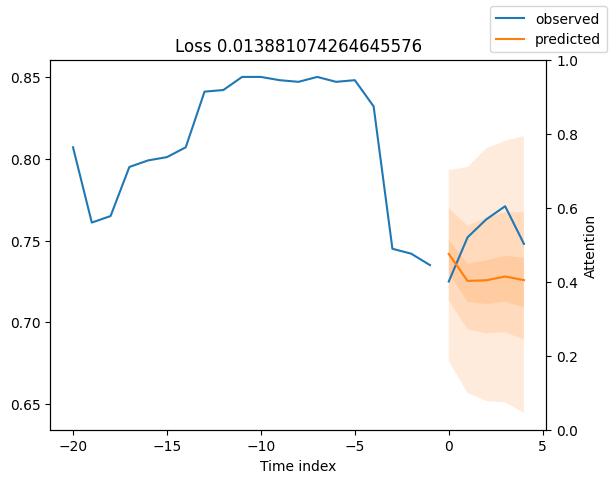

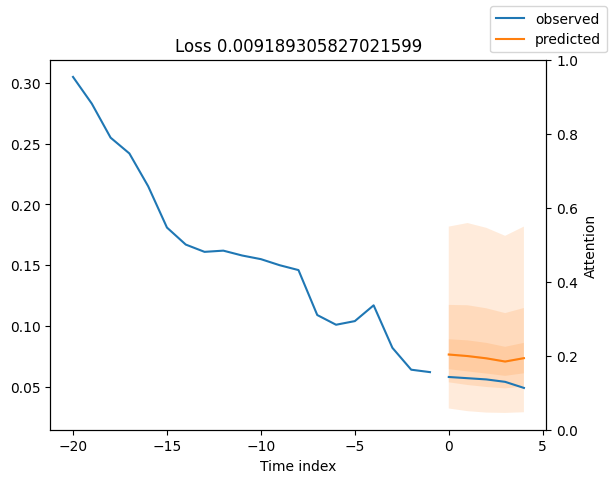

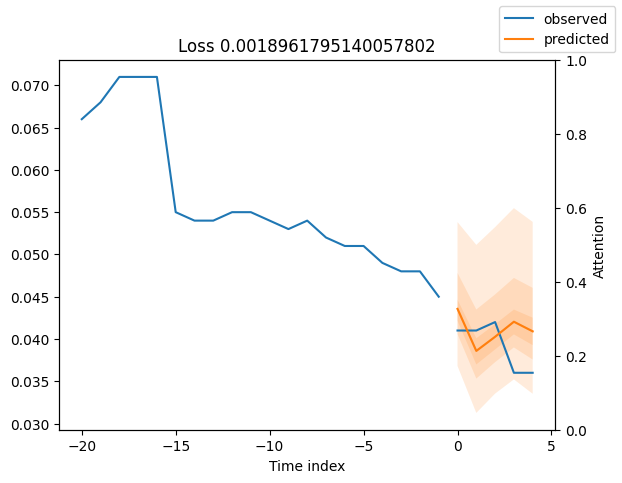

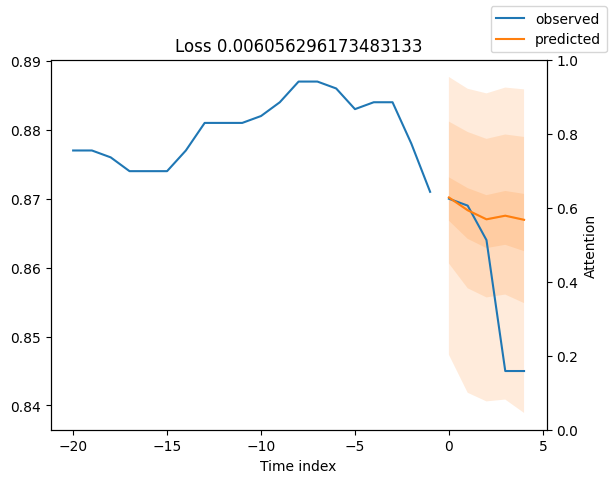

In [18]:
# 1. Define Helper Function for Forecasting
import matplotlib.pyplot as plt

def plot_country_forecast(model, country_name, raw_data):
    print(f"\n--- Forecasting for {country_name} ---")

    # A. Filter Data for Country
    # We use the global 'data' dataframe which contains the raw loaded data
    country_data = raw_data[raw_data["country_name"] == country_name].copy()

    if country_data.empty:
        print(f"Country '{country_name}' not found in data.")
        return

    # B. Re-apply Feature Engineering from setup_tft_dataset
    # The model expects data exactly as it saw during training

    # Clean Identifiers
    country_data["COWcode"] = pd.to_numeric(country_data["COWcode"], errors='coerce')
    country_data["year"] = pd.to_numeric(country_data["year"], errors='coerce')
    country_data = country_data.dropna(subset=["COWcode", "year", "v2x_libdem"])

    if len(country_data) < 20:  # heuristic check for minimum length
        print(f"Not enough data points for {country_name} (found {len(country_data)}).")
        return

    # Sanitize Economic Variables
    cols_to_clip = ["unified_gdp_pc", "unified_pop", "resource_rents"]
    for col in cols_to_clip:
        if col in country_data.columns:
            country_data[col] = country_data[col].clip(lower=0)

    if "unified_gdp_pc" in country_data.columns:
        country_data["log_gdp_pc"] = np.log1p(country_data["unified_gdp_pc"])
    if "unified_pop" in country_data.columns:
        country_data["log_pop"] = np.log1p(country_data["unified_pop"])

    real_cols = [
        "unified_gdp_pc", "log_gdp_pc", "unified_pop", "fraser_bmp_score",
        "unified_corruption", "resource_rents", "gini_disp", "atop_defense_with_auto"
    ]
    for col in real_cols:
        if col in country_data.columns:
            country_data[col] = country_data[col].fillna(0)

    # Cast Categoricals
    country_data["COWcode"] = country_data["COWcode"].astype(int).astype(str).astype("category")
    country_data["year"] = country_data["year"].astype(int)
    country_data["time_idx"] = country_data["year"]

    force_categoricals = [
        "is_petro_state", "is_aut_episode", "is_dem_episode", "alba_member",
        "mid_count_total", "mid_high_fatality_event", "is_leftist_leader",
        "is_rightist_leader", "gli_leader_ideology_num", "mid_max_fatality_cat",
        "mid_max_hostility"
    ]

    for var in force_categoricals:
        if var in country_data.columns:
            try:
                if country_data[var].dtype.name == 'category':
                     country_data[var] = country_data[var].astype(str).astype("category")
                else:
                    # numeric to int to string to category
                    country_data[var] = pd.to_numeric(country_data[var], errors='coerce').fillna(-1)
                    country_data[var] = country_data[var].astype(int).astype(str).astype("category")
            except Exception:
                country_data[var] = country_data[var].astype(str).astype("category")

    # C. Predict & Plot
    try:
        # predict() can accept a dataframe directly. It handles creating the dataset.
        # return_x=True returns a tuple (prediction, x, index, decoder_lengths...)
        # We only need the first two.
        ret = model.predict(country_data, mode="raw", return_x=True)
        raw_prediction = ret[0]
        x = ret[1]

        # Plot the LAST available prediction window (the most future-looking one)
        # idx=-1 selects the last sequence generated from the data
        model.plot_prediction(x, raw_prediction, idx=-1, add_loss_to_title=True)
        plt.title(f"Democracy Score Forecast: {country_name}")
        plt.show()

    except Exception as e:
        print(f"Prediction failed for {country_name}: {e}")

# 2. Run for selected countries
# Note: 'data' is the global dataframe from Step 2
countries_to_plot = ["United States of America", "Venezuela", "China", "Sweden"]

for country in countries_to_plot:
    plot_country_forecast(model, country, data)